## TS Forecast Proof of Concept

In [1]:
import os
os.chdir(os.environ['PWD'])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
from app.conf import model_utils as muts
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#### Import Historical Data

In [3]:
dataset_filtered = uts.load_artifact('prices_dataframe', sts.LOCAL_ARTIFACTS_PATH)

In [4]:
dataset_filtered

,date,group,product,market,mean_price
0,2013-01-01,carnes,alas de pollo con costillar,armenia mercar,NaN
1,2013-02-01,carnes,alas de pollo con costillar,armenia mercar,NaN
2,2013-03-01,carnes,alas de pollo con costillar,armenia mercar,NaN
3,2013-04-01,carnes,alas de pollo con costillar,armenia mercar,NaN
4,2013-05-01,carnes,alas de pollo con costillar,armenia mercar,NaN
...,...,...,...,...,...
406023,2022-07-01,verduras y hortalizas,zanahoria larga vida,sonson antioquia,1428
406024,2022-08-01,verduras y hortalizas,zanahoria larga vida,sonson antioquia,1701
406025,2022-09-01,verduras y hortalizas,zanahoria larga vida,sonson antioquia,1729
406026,2022-10-01,verduras y hortalizas,zanahoria larga vida,sonson antioquia,833


In [5]:
dataset_filtered['date'] = pd.to_datetime(dataset_filtered['date'])

## Time Series Forecasting

In [6]:
date_range = pd.date_range(
    start = dataset_filtered['date'].min(), 
    end = dataset_filtered['date'].max(), 
    freq = 'MS'
)

In [7]:
price_series = dataset_filtered.loc[
    (dataset_filtered['group'] == 'frutas')&
    (dataset_filtered['product'] == 'manzana roja importada')&
    (dataset_filtered['market'] == 'medellin central mayorista de antioquia'),
    ['mean_price', 'date']
].set_index('date').reindex(date_range).squeeze()

In [8]:
y = price_series.copy()

In [9]:
series_start_period = y.first_valid_index()

In [10]:
test_size = 3

In [11]:
y_train = y[series_start_period:].iloc[:-test_size]
y_test = y.iloc[-test_size:]

In [12]:
y_train.tail()

2022-04-01    7492
2022-05-01    7014
2022-06-01    6774
2022-07-01    7016
2022-08-01    7513
Freq: MS, Name: mean_price, dtype: object

In [13]:
y_test.head()

2022-09-01    8101
2022-10-01    7928
2022-11-01    8228
Freq: MS, Name: mean_price, dtype: object

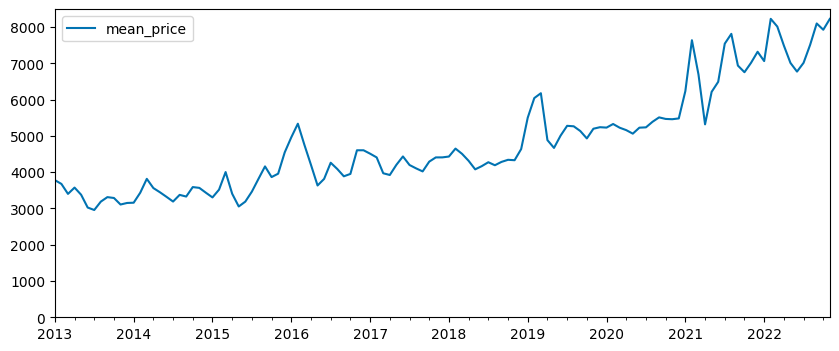

In [14]:
plt.figure(figsize=(10,4))
y.plot()
plt.ylim(bottom=0)
plt.legend()
plt.show()

#### Time Series Decomposition w/ LOESS

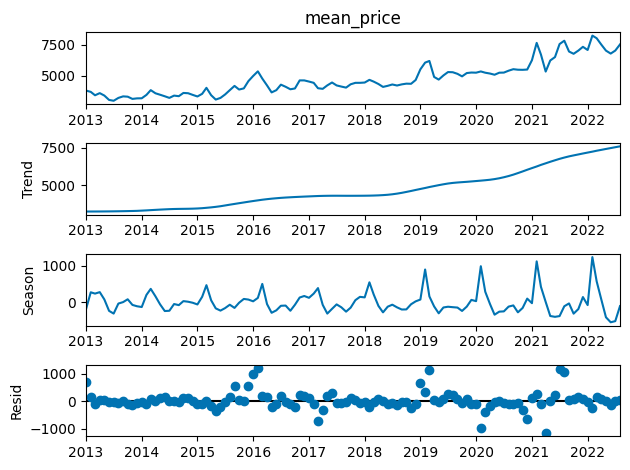

In [15]:
stl = STL(y_train, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

In [16]:
f_t = max(0, 1 - res_robust.resid.var()/(res_robust.trend + res_robust.resid).var())
print("f_t", f_t)

f_t 0.9335900191489662


In [17]:
f_s = max(0, 1 - res_robust.resid.var()/(res_robust.seasonal + res_robust.resid).var())
print("f_s", f_s)

f_s 0.3650584451697708


### Model Fit

#### Model 1 features (Trend and Seasonality)

In [18]:
dp = DeterministicProcess(
    index = y_train.index,
    constant = True,
    order = (2 if f_t > 0.5 else 0),
    drop = True,
    seasonal = (True if f_s > 0.5 else False)
)

In [19]:
# Trend Component + Seasonality (if significant)
X_1_train = dp.in_sample()
X_1_test = dp.out_of_sample(steps=y_test.shape[0])

#### Model 1 fit

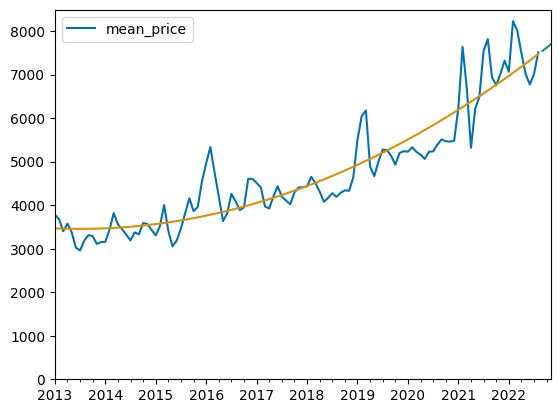

In [20]:
model_1 = LinearRegression().fit(X_1_train, y_train)
y_fitted_1 = pd.Series(model_1.predict(X_1_train), index=X_1_train.index)
y_pred_1 = pd.Series(model_1.predict(X_1_test), index=X_1_test.index)
ax = y_train.plot()
ax = y_fitted_1.plot()
ax = y_pred_1.plot()
ax.legend()
plt.ylim(bottom=0)
plt.show()

#### Get Model 1 Residuals (Model 2 TS)

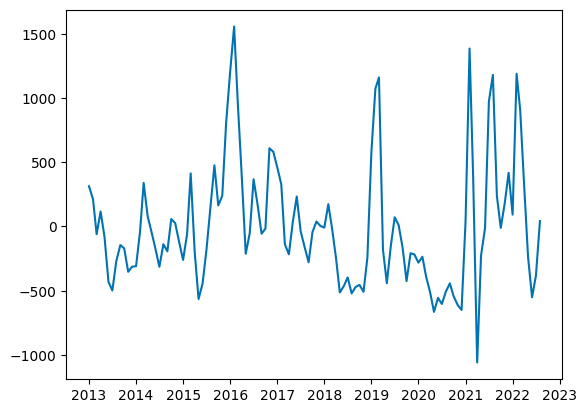

In [21]:
residuals = y_train - y_fitted_1
plt.plot(residuals)
plt.show()

#### Model 2 features (residual lags)

In [22]:
X_2_train = muts.make_lags_features(residuals, 3).dropna()
X_2_test = X_2_train.iloc[-1:]
y_2_train = muts.make_multistep_target(residuals, test_size).dropna()

In [23]:
y_2_train, X_2_train = y_2_train.align(X_2_train, join='inner', axis=0)

In [24]:
X_2_train.tail()

,y_lag_1,y_lag_2,y_lag_3,y_rolling_std
2022-02-01,91.997169,417.627659,180.581578,168.361347
2022-03-01,1187.690107,91.997169,417.627659,562.668405
2022-04-01,904.706475,1187.690107,91.997169,568.788064
2022-05-01,310.046271,904.706475,1187.690107,447.950741
2022-06-01,-239.290503,310.046271,904.706475,572.148106


In [25]:
y_2_train.tail()

,y_step_1,y_step_2,y_step_3
2022-02-01,1187.690107,904.706475,310.046271
2022-03-01,904.706475,310.046271,-239.290503
2022-04-01,310.046271,-239.290503,-551.303848
2022-05-01,-239.290503,-551.303848,-381.993765
2022-06-01,-551.303848,-381.993765,41.639748


In [26]:
residuals.tail()

2022-04-01    310.046271
2022-05-01   -239.290503
2022-06-01   -551.303848
2022-07-01   -381.993765
2022-08-01     41.639748
Freq: MS, dtype: object

In [27]:
X_2_test

,y_lag_1,y_lag_2,y_lag_3,y_rolling_std
2022-08-01,-381.993765,-551.303848,-239.290503,156.195632


#### Model 2 fit

In [28]:
model = MultiOutputRegressor(LinearRegression())
model.fit(X_2_train, y_2_train)

MultiOutputRegressor(estimator=LinearRegression())

In [29]:
y_fitted_2 = pd.DataFrame(model.predict(X_2_train), index=X_2_train.index, columns=y_2_train.columns)
y_pred_2 = pd.Series(model.predict(X_2_test).reshape(-1,), index = y_pred_1.index, dtype = float)

In [30]:
print("y_fitted_2.shape",y_fitted_2.shape)
print("y_pred_2.shape",y_pred_2.shape)

y_fitted_2.shape (111, 3)
y_pred_2.shape (3,)


In [31]:
y_pred = y_pred_1 + y_pred_2
y_fitted = y_fitted_1 + y_fitted_2['y_step_1']

#### Final model residuals: y_true - (y_pred_model_1 + y_pred_model_2)

In [32]:
model_res_std = (y_train - y_fitted).dropna().std()

In [33]:
model_res_std

340.9272643389542

#### Forecast Intervals (Naive Method)

In [34]:
conf_int = model_res_std * np.sqrt(np.arange(1, y_test.shape[0]+1))

In [35]:
y_pred.index

DatetimeIndex(['2022-09-01', '2022-10-01', '2022-11-01'], dtype='datetime64[ns]', freq='MS')

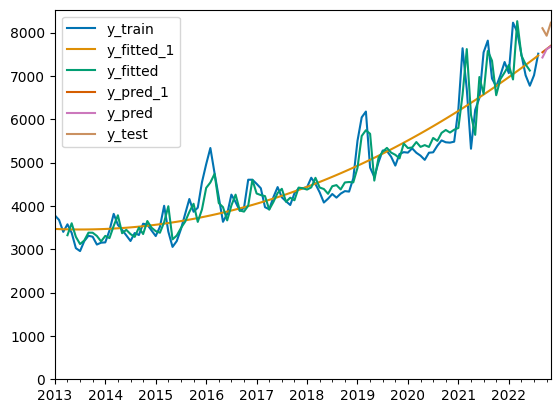

In [36]:
y_train.plot(label = 'y_train')
y_fitted_1.plot(label = 'y_fitted_1')
y_fitted.plot(label = 'y_fitted')
y_pred_1.plot(label = 'y_pred_1')
y_pred.plot(label = 'y_pred')
y_test.plot(label = 'y_test')
#plt.fill_between(y_pred.index, y_pred - conf_int, y_pred + conf_int, alpha = 0.5)
plt.legend()
plt.ylim(bottom=0)
plt.show()

---

### Evaluation Metrics

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#### Training Set

In [38]:
print(f"MAPE y_train - y_fitted_1 = {mean_absolute_percentage_error(y_train, y_fitted_1)}")

MAPE y_train - y_fitted_1 = 0.07391271724681825


In [39]:
y_train_ri, y_fitted = y_train.dropna().align(y_fitted.dropna(), join='inner', axis=0)

In [40]:
print(f"MAPE y_train - y_fitted = {mean_absolute_percentage_error(y_train_ri, y_fitted)}")

MAPE y_train - y_fitted = 0.050297511685776675


#### Test Set

In [41]:
print(f"MAPE y_test - y_pred_1 = {mean_absolute_percentage_error(y_test, y_pred_1)}")

MAPE y_test - y_pred_1 = 0.057377855480354616


In [42]:
print(f"MAPE y_test - y_pred = {mean_absolute_percentage_error(y_test, y_pred)}")

MAPE y_test - y_pred = 0.06302498507585119


---

### Simulate prediction for one TS

1. Get Model 1 (Deterministic Model) inputs

In [43]:
X_1, X_fore_1 = muts.get_X_det(y, forecast_steps = 1)

2. Fit Model 1 and retrieve model, fitted values and residuals

In [44]:
model_1, y_pred_1, residuals = muts.get_model(y, X_1, LinearRegression(), return_residuals = True)

3. Get Model 2 (Residual Model) inputs 

In [45]:
y_2, X_fore_2, X_2 = muts.get_X_res(residuals, 3)

4. Fit Model 2 and retrieve model, fitted values and residuals

In [46]:
model_2, y_pred_2 = muts.get_model(y_2, X_2, LinearRegression(), return_residuals=False)

5. Get Final Model (Model 1 + Model 2) fitted values

In [47]:
y_pred = y_pred_1 + y_pred_2

6. Compute Final Model Residuals

In [48]:
res_std = (y - y_pred).dropna().std()

7. Get 1-step ahead prediction

In [49]:
prediction = muts.get_prediction((model_1, model_2), (X_fore_1, X_fore_2), res_std)

In [50]:
print(prediction)

{'point': 7832.150237254959, 'lower': 7492.50863499721, 'upper': 8171.791839512709, 'index': Timestamp('2022-12-01 00:00:00', freq='MS')}
